In [2]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
from datetime import datetime 
import numpy as np
import os, random, math, time
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
def read_file(filename):
    df = pd.read_csv(f'{filename}', encoding="cp949")
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def check_NA(df):
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

In [4]:
filepath = "./data"

In [6]:
waste = read_file(os.path.join(filepath,'01_음식물쓰레기_FOOD_WASTE_210811_update.csv'))
resid_pop = read_file(os.path.join(filepath,'03_거주인구_RESIDENT_POP.csv'))
card = read_file(os.path.join(filepath,'04_음식관련 카드소비_CARD_SPENDING.csv'))
pop_korean = read_file(os.path.join(filepath,'02-1_내국인유동인구_KOREAN.CSV'))
pop_long = read_file(os.path.join(filepath,"02-2_장기체류 외국인 유동인구_LONG_TERM_FRGN.CSV"))
pop_short = read_file(os.path.join(filepath,'02-3_단기체류 외국인 유동인구_SHORT_TERM_FRGN.CSV'))

...There are no duplicates
shape: (2211445, 8)
...There are no duplicates
shape: (3612, 9)
...There are no duplicates
shape: (544805, 8)
...There are no duplicates
shape: (47250196, 11)
...There are no duplicates
shape: (23837317, 10)
...There are no duplicates
shape: (6059044, 7)


In [5]:
r_waste = deepcopy(waste)
r_card = deepcopy(card)
r_resid_pop = deepcopy(resid_pop)

In [6]:
waste_ = deepcopy(r_waste)
card = deepcopy(r_card)
resid_pop = deepcopy(r_resid_pop)

# 1. 음식물 쓰레기 데이터

In [7]:
waste_.columns

Index(['base_date', 'city', 'emd_cd', 'emd_nm', 'em_area_cd', 'em_cnt', 'em_g',
       'pay_amt'],
      dtype='object')

## 배출거점개수 시각화

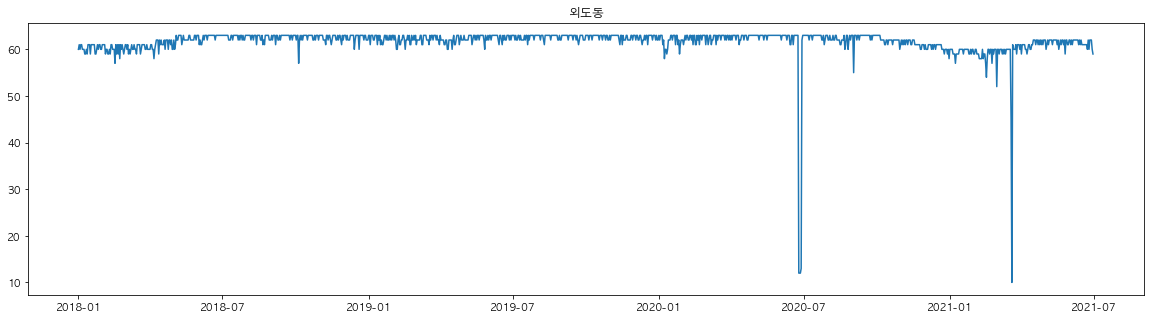

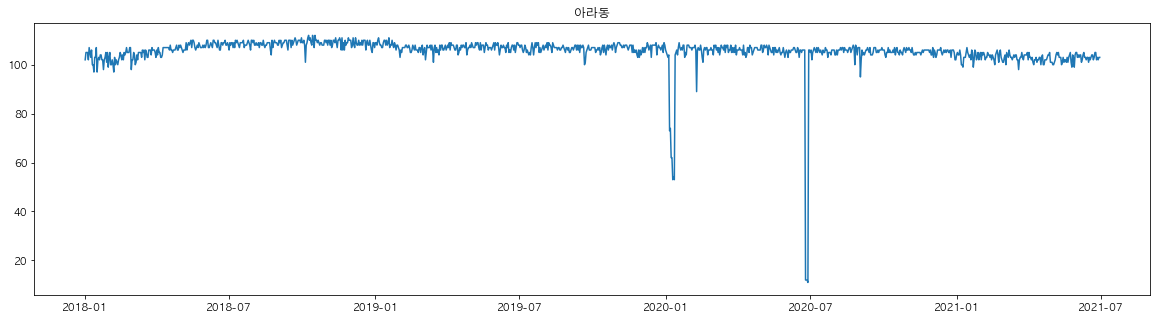

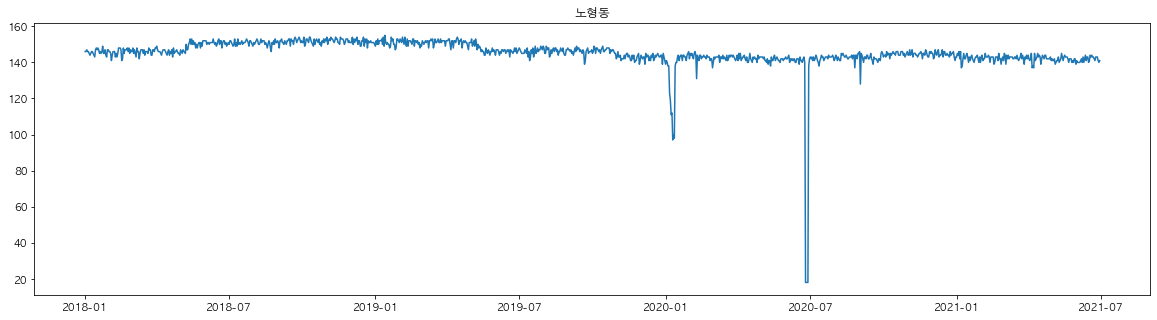

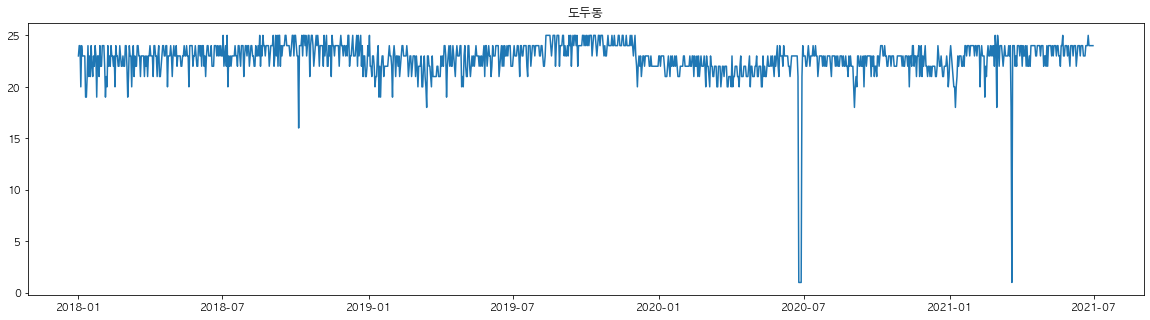

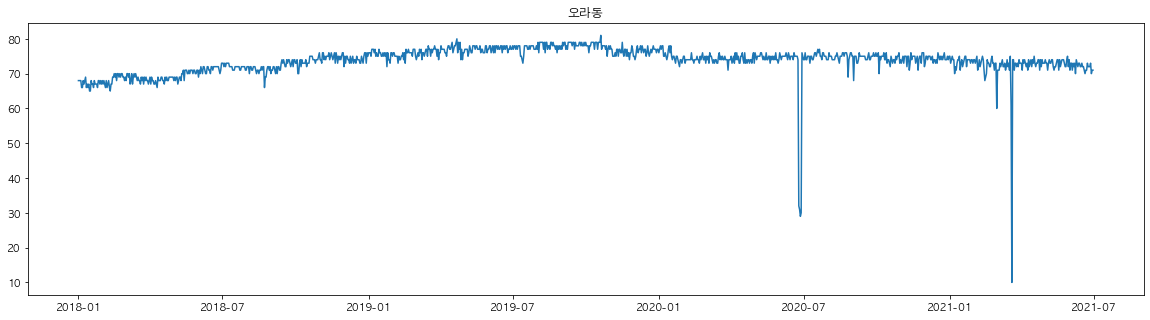

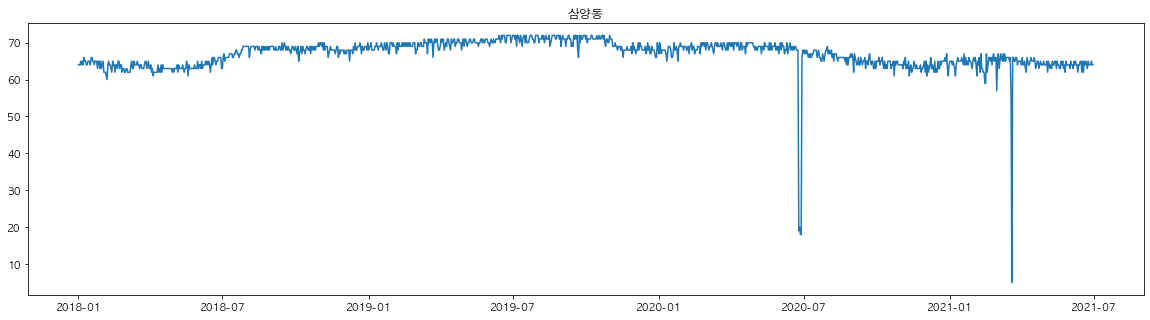

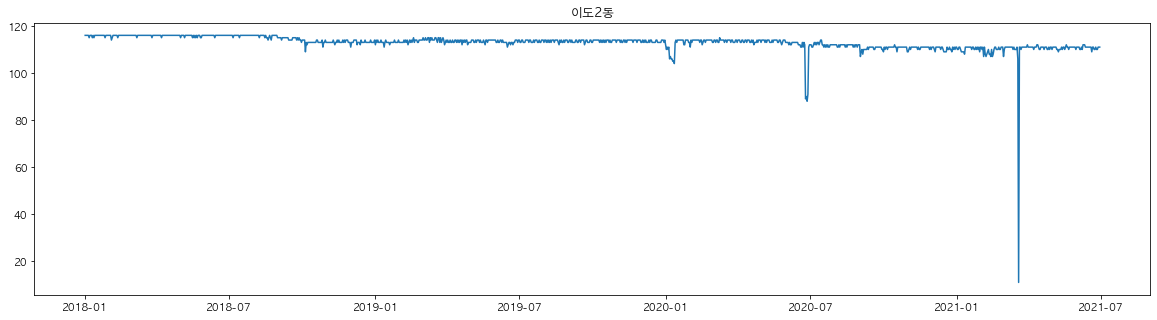

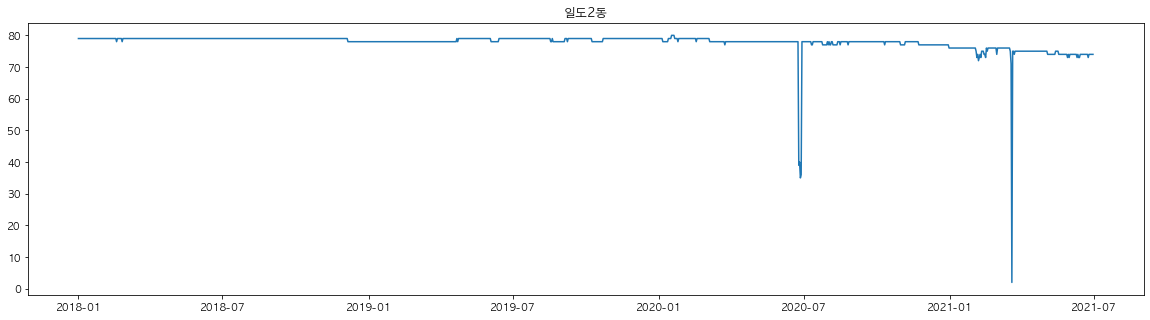

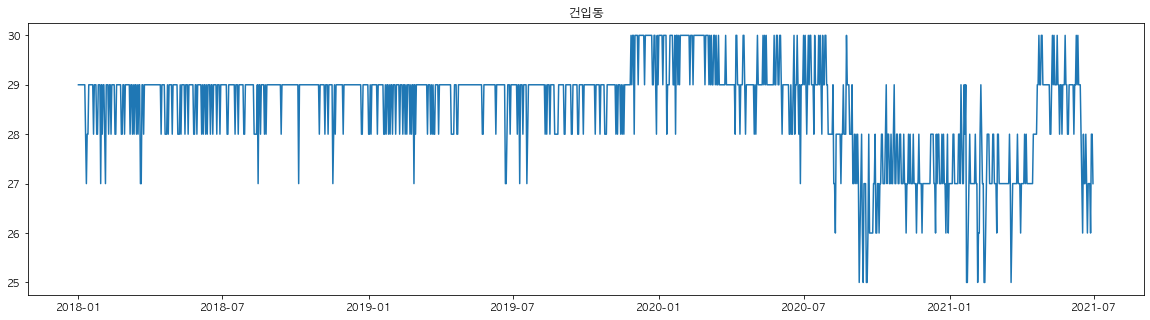

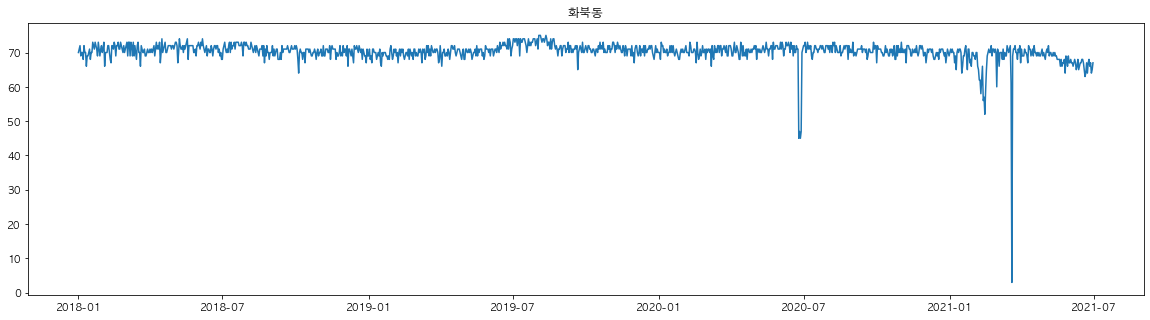

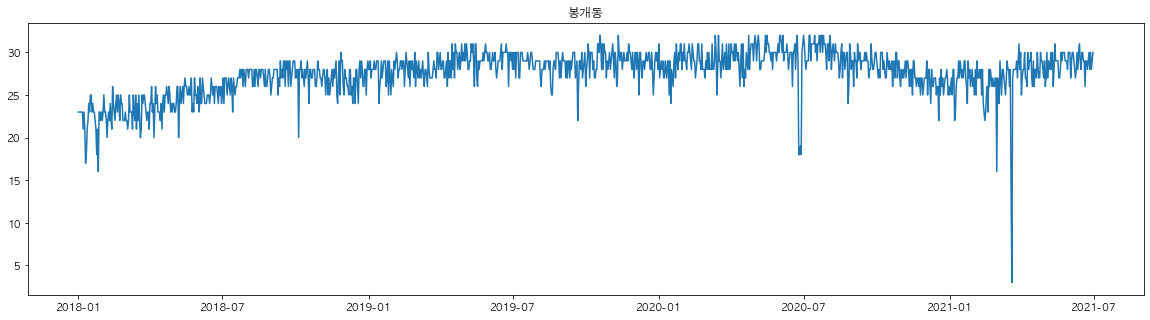

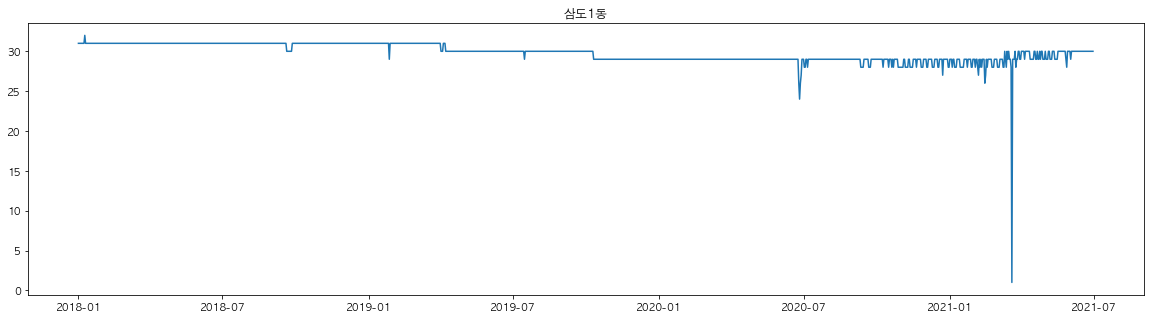

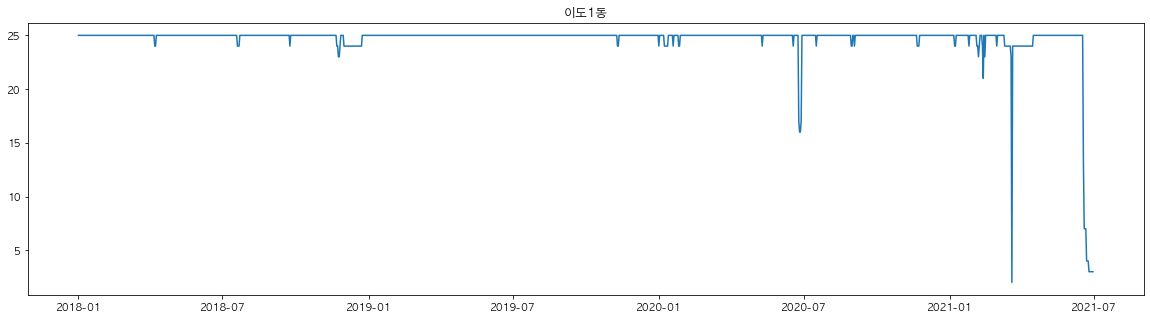

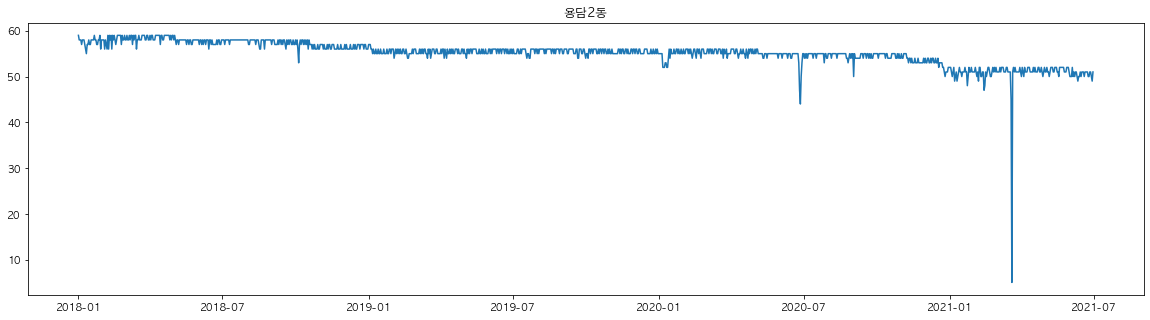

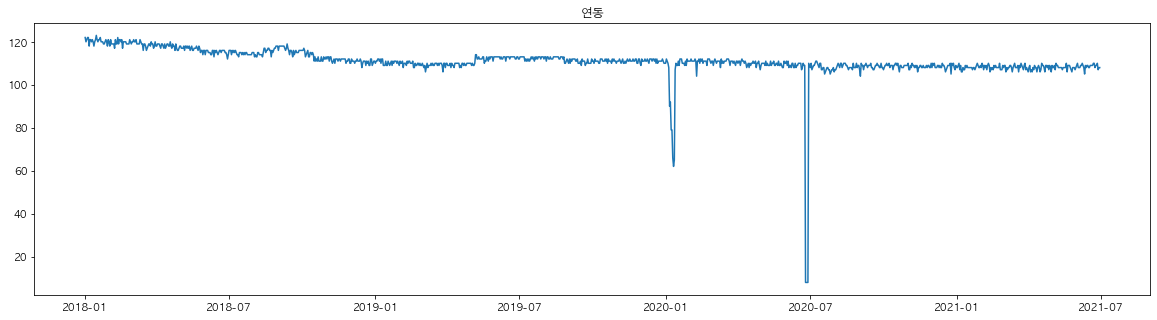

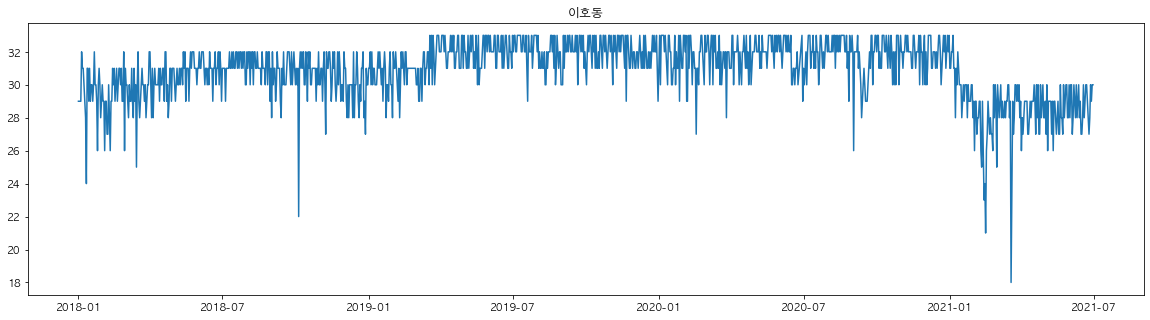

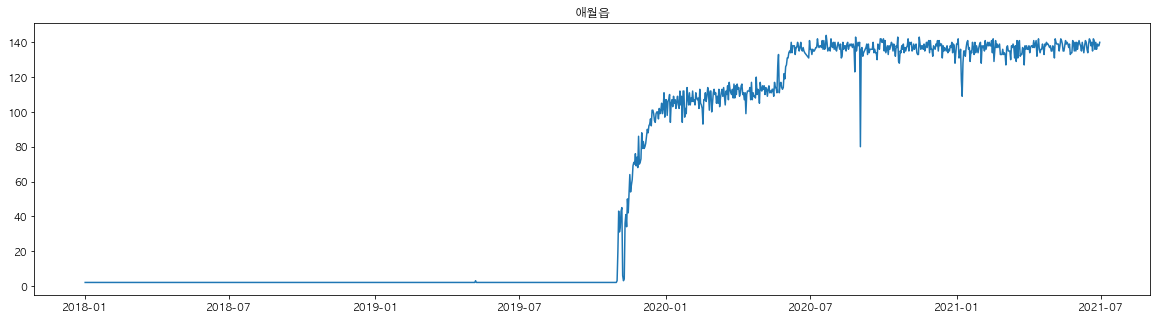

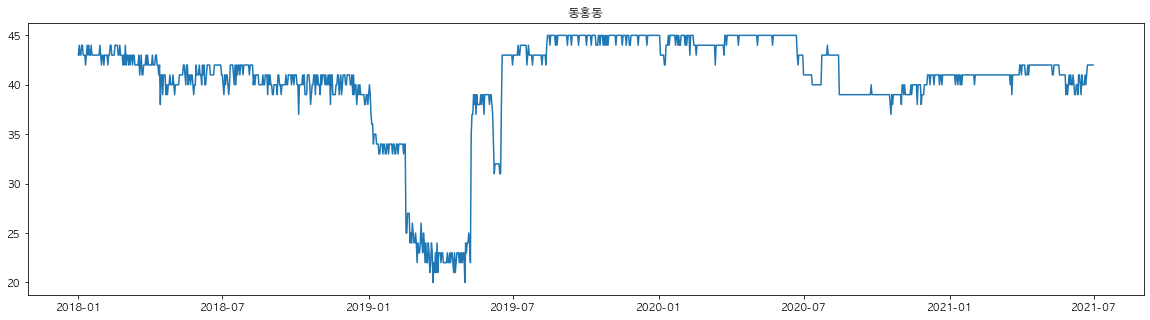

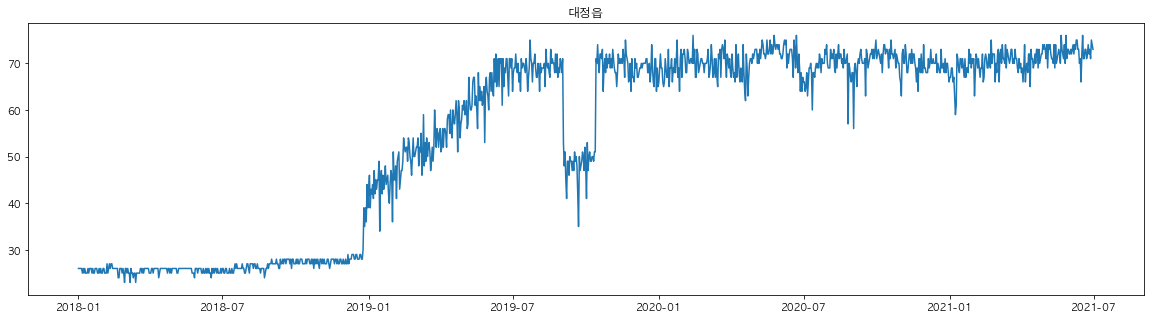

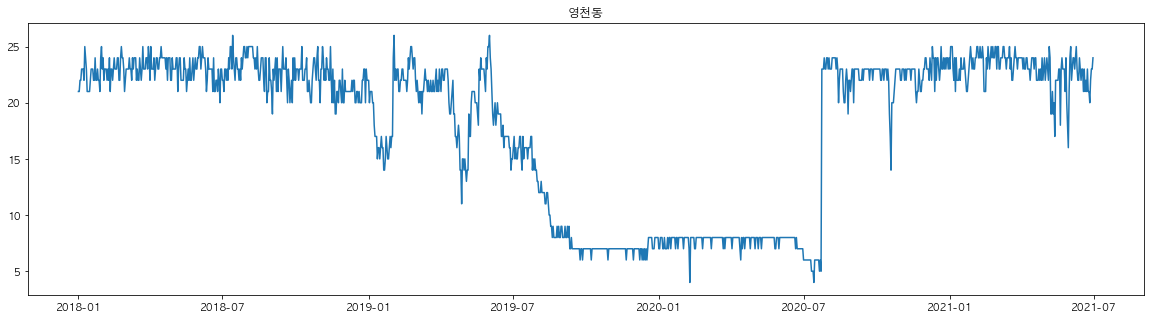

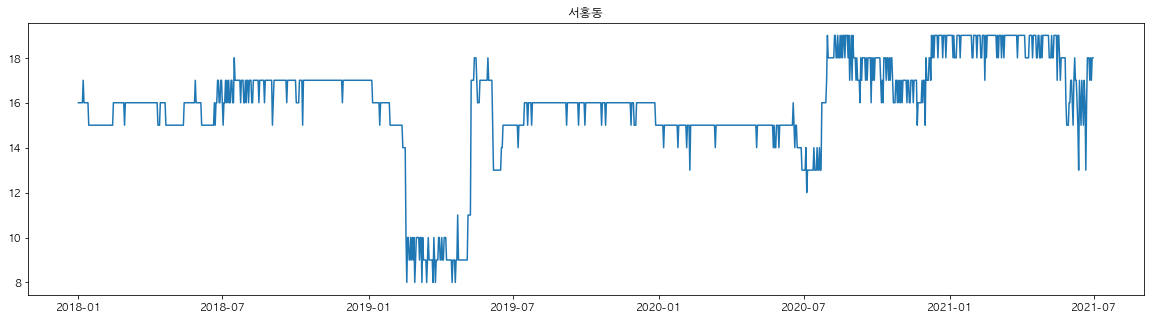

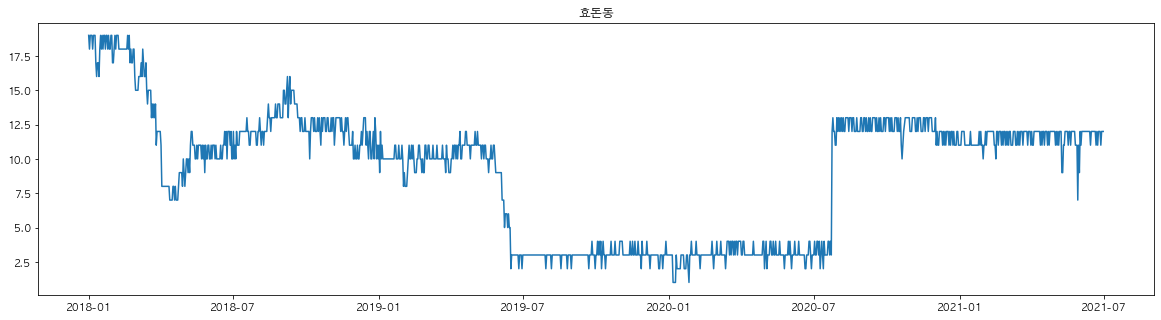

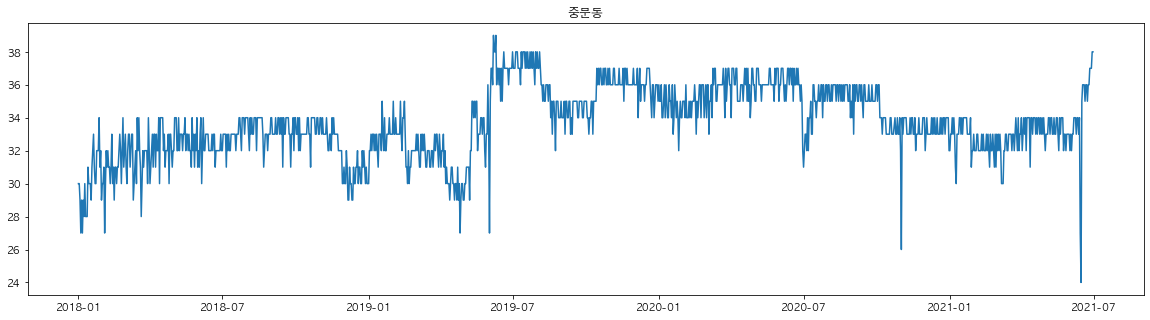

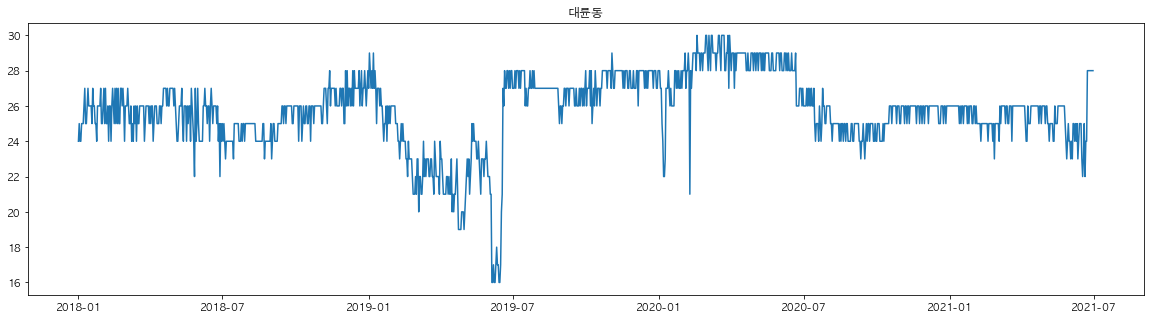

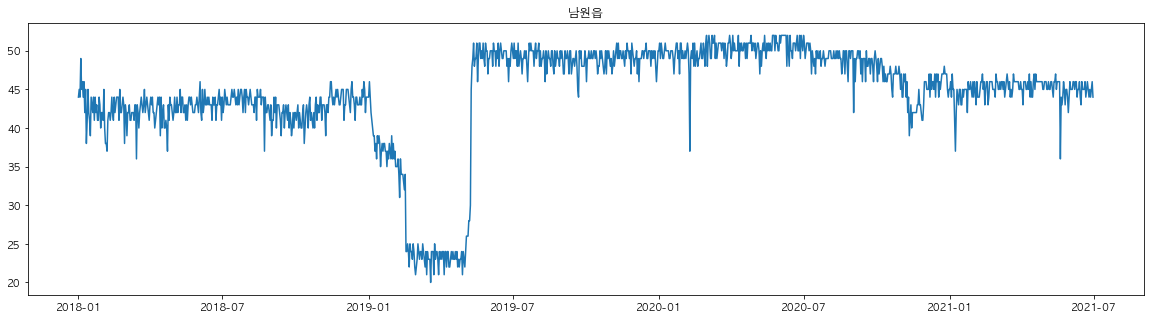

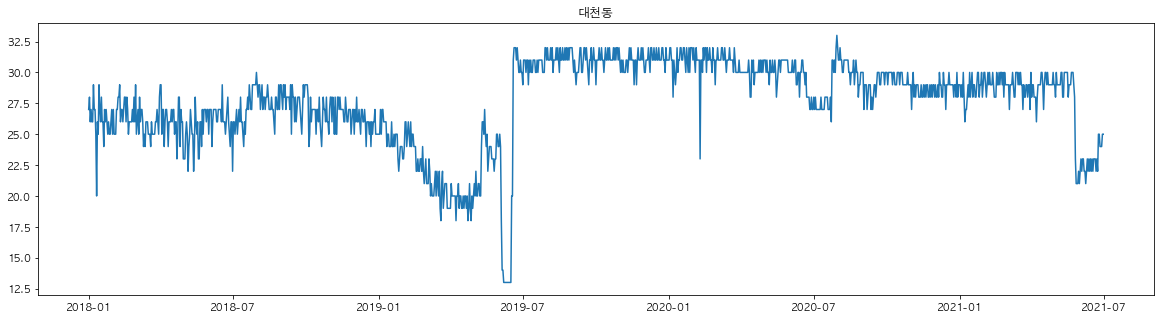

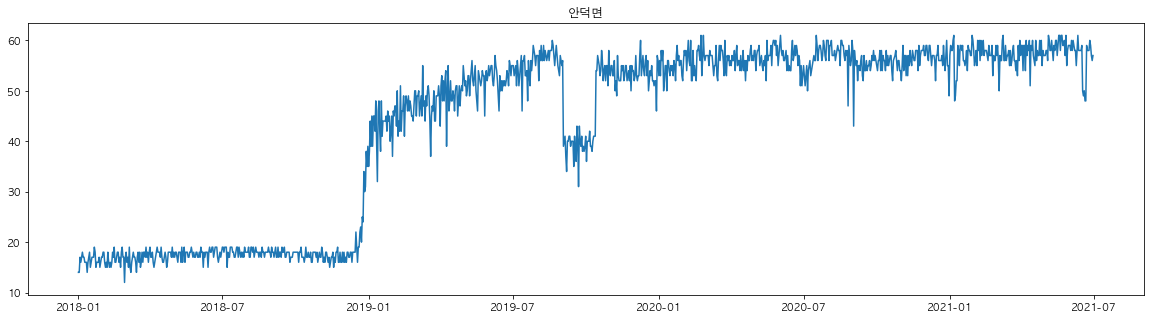

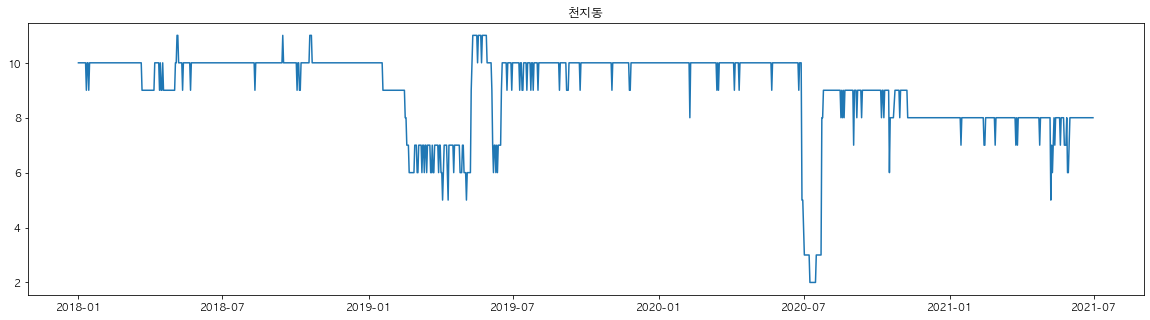

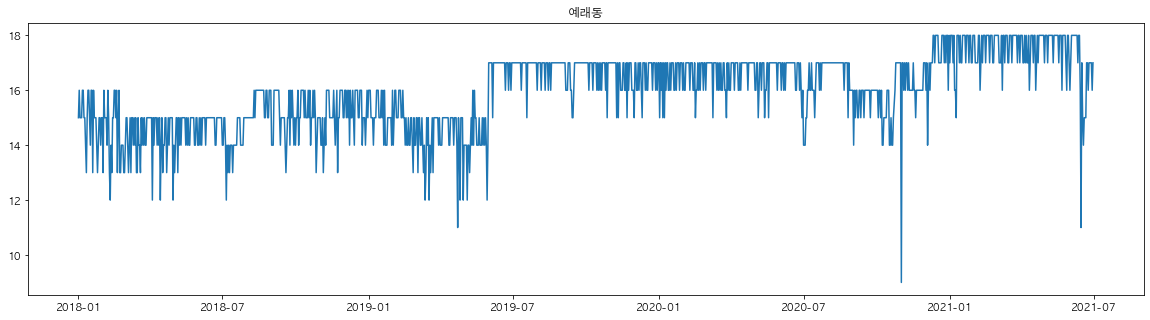

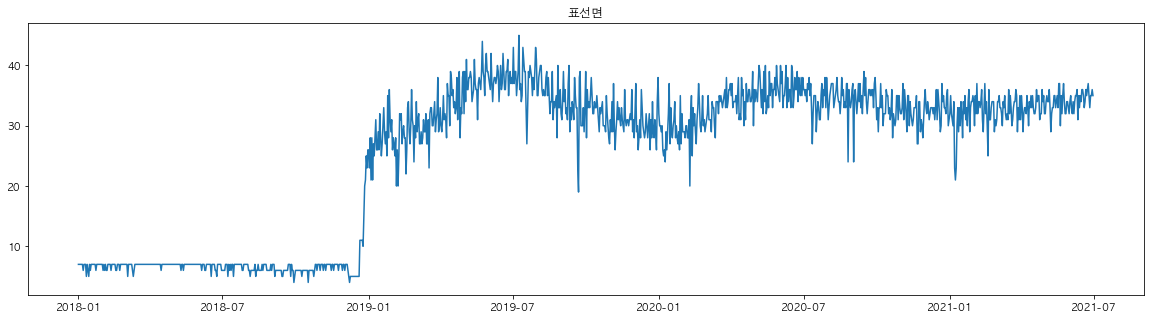

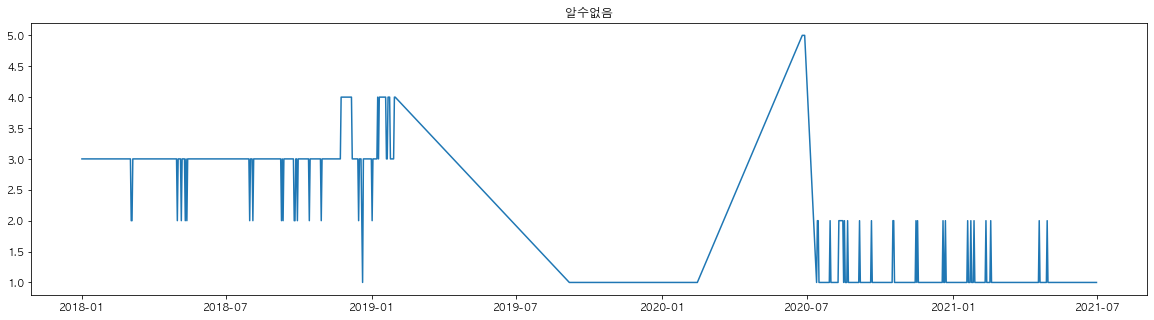

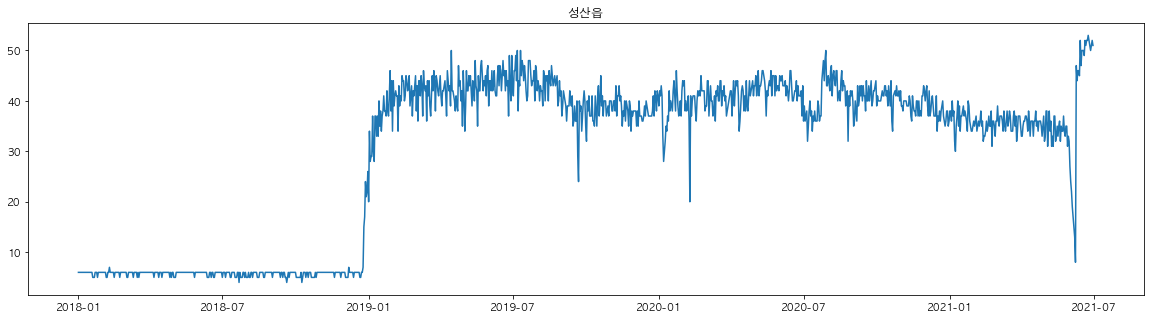

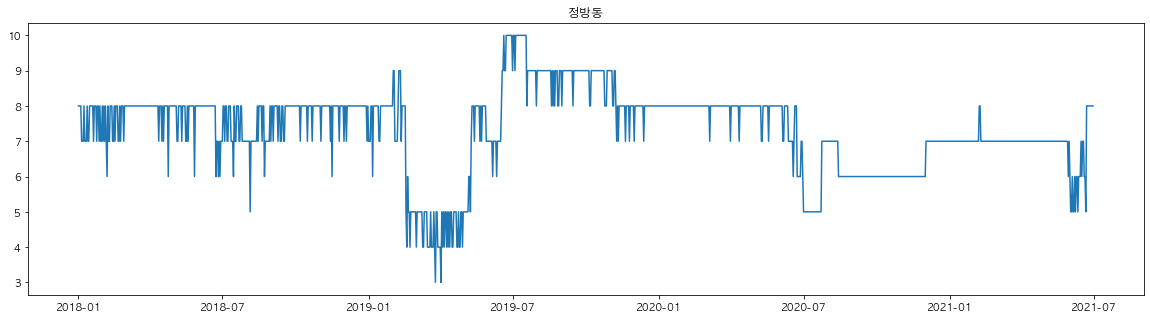

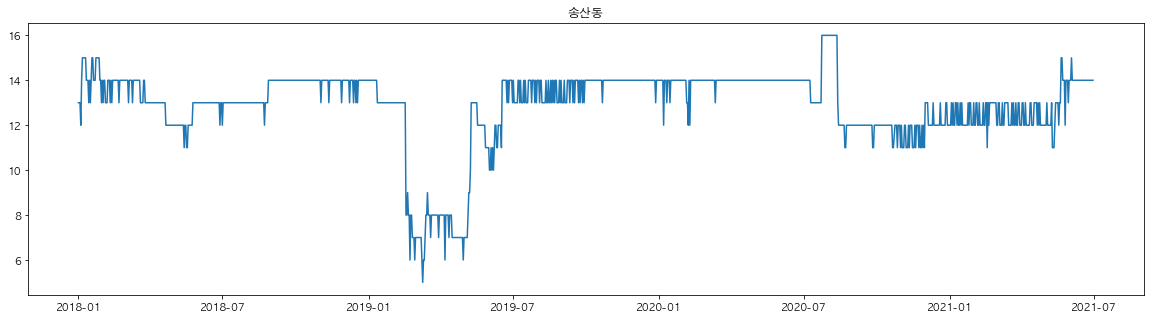

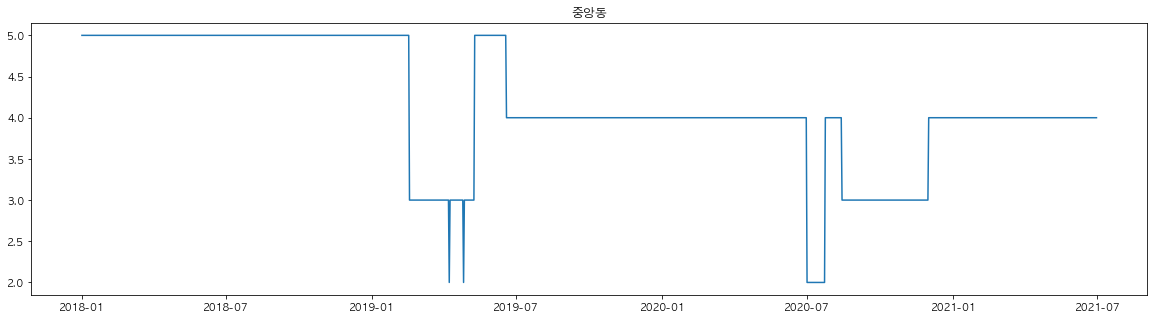

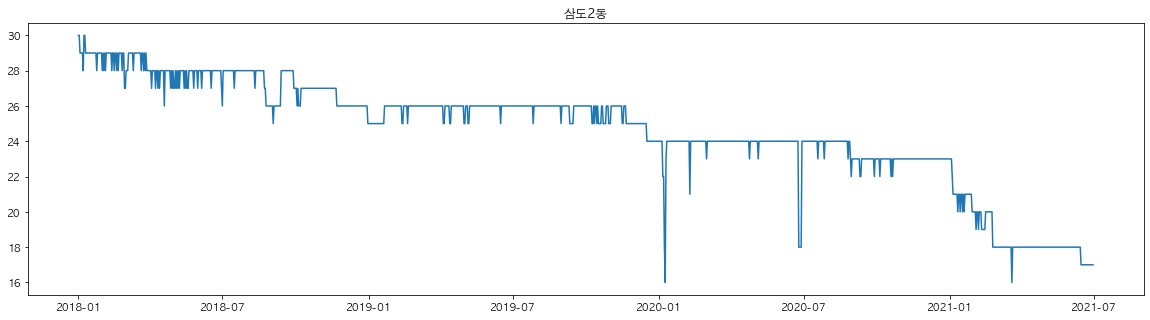

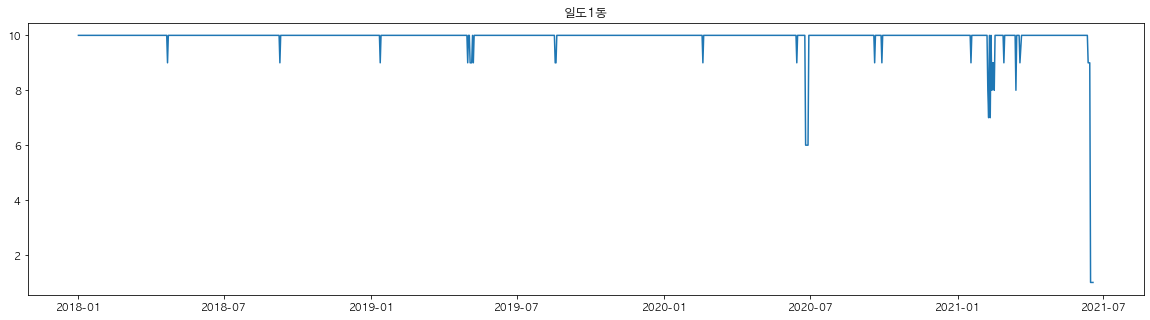

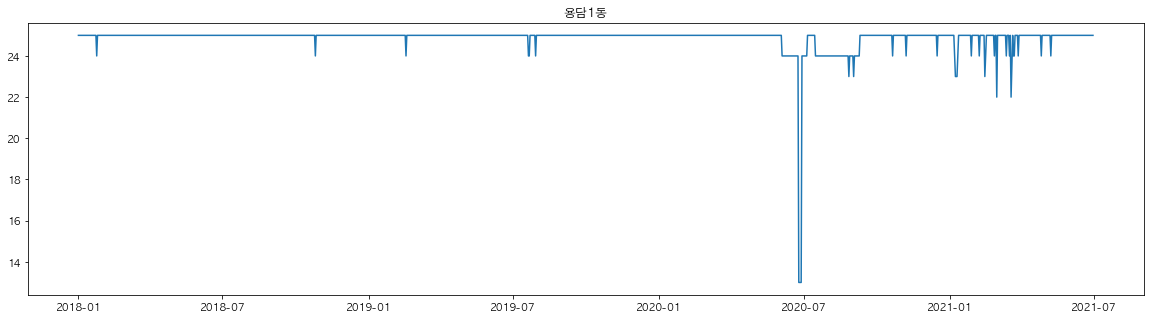

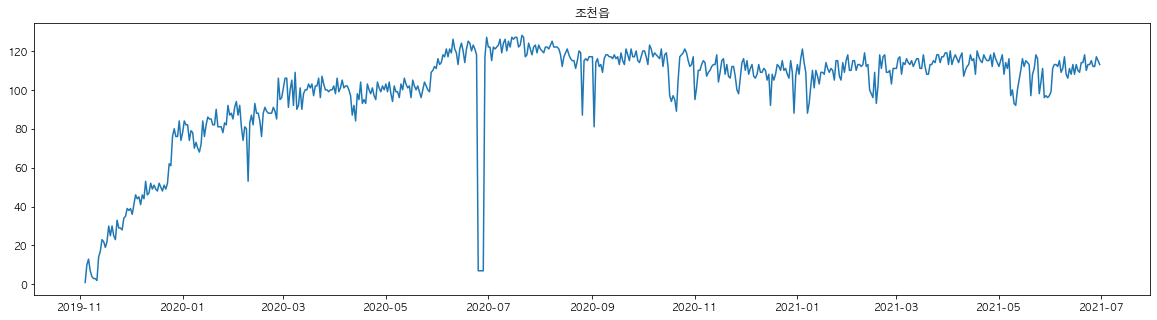

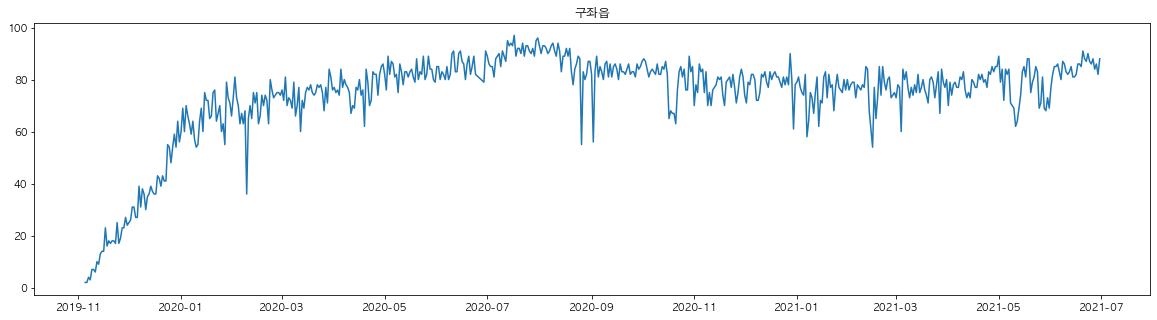

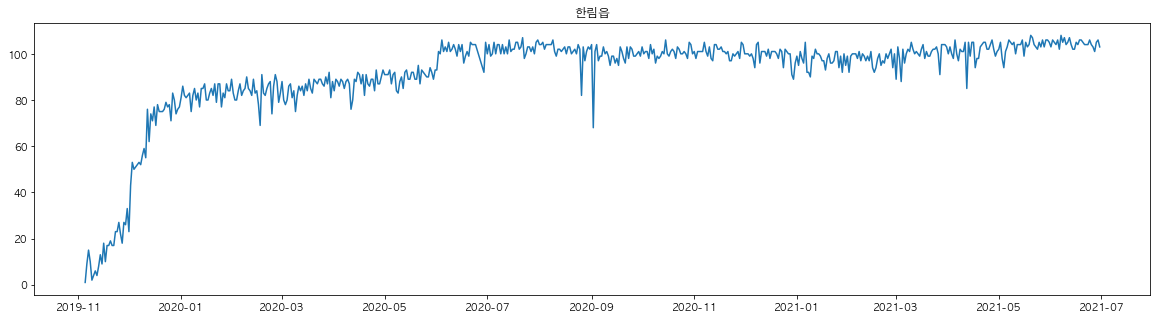

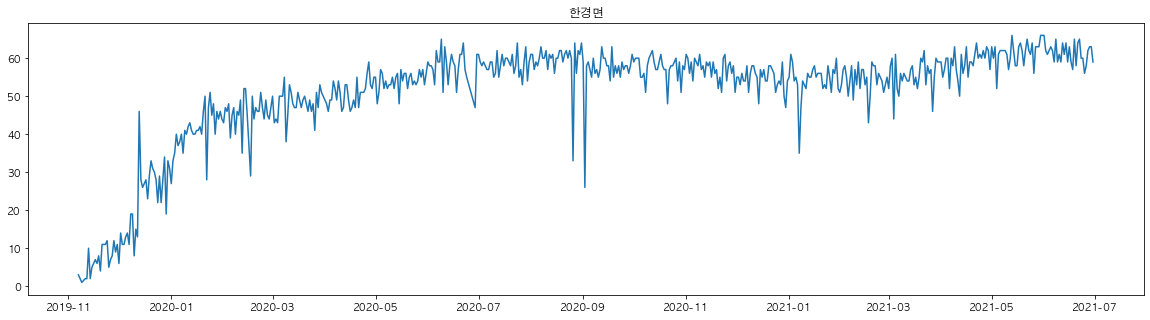

In [8]:
for emd in waste_.emd_nm.unique():
    tmp = waste_.loc[waste_.emd_nm==emd]
    tmp = tmp[['base_date','emd_nm','em_area_cd']]
    pi = tmp.pivot_table(index="base_date",values='em_area_cd',aggfunc="nunique").reset_index()
    fig,ax = plt.subplots(figsize=(20,5))
    pi['base_date'] = pd.DatetimeIndex(pi['base_date'])
    plt.plot(pi['base_date'],pi['em_area_cd'])
    plt.title(emd)
    plt.show()

In [9]:
pi = waste_[['base_date','emd_nm','em_area_cd']].pivot_table(index=["base_date","emd_nm"],values='em_area_cd',aggfunc="nunique").reset_index()
pi.columns = ['base_date', 'emd_nm', 'em_area_cd_cnt']
pi.head()

,base_date,emd_nm,em_area_cd_cnt
0,2018-01-01,건입동,29
1,2018-01-01,남원읍,44
2,2018-01-01,노형동,146
3,2018-01-01,대륜동,24
4,2018-01-01,대정읍,26


## 배출거점코드별로 sum

In [10]:
print(waste_.shape)
waste = waste_.groupby(['base_date','city','emd_nm']).sum().reset_index()
print(waste.shape)

(2211445, 8)
(50522, 6)


In [11]:
waste__ = pd.merge(waste, pi, on=['base_date', 'emd_nm'], how='left')
waste__

,base_date,city,emd_nm,em_cnt,em_g,pay_amt,em_area_cd_cnt
0,2018-01-01,서귀포시,남원읍,304,1239600,37110,44
1,2018-01-01,서귀포시,대륜동,650,1717700,50076,24
2,2018-01-01,서귀포시,대정읍,309,1264950,37872,26
3,2018-01-01,서귀포시,대천동,696,1765600,52008,27
4,2018-01-01,서귀포시,동홍동,1567,4165050,122434,43
...,...,...,...,...,...,...,...
50517,2021-06-30,제주시,일도2동,2856,4963450,148195,74
50518,2021-06-30,제주시,조천읍,981,2175450,65043,113
50519,2021-06-30,제주시,한경면,269,973850,29152,59
50520,2021-06-30,제주시,한림읍,870,3298100,98740,103


# 2. 카드 데이터

## 업종 그룹핑 column 추가

In [12]:
card.mct_cat_nm = card.mct_cat_nm.replace('마트/슈퍼마켓','마트')
card['use_ratio'] = card['use_amt']/card['use_cnt']
card = card.loc[~card.emd_nm.isin(['우도면','추자면'])]
mct_dict = {'cat1': ['한식','패스트푸드','아시아음식'],
            'cat2': ['주점및주류판매','양식'],
            'cat3': ['마트','식품','간식'],
            'cat4': ['배달'],
            'cat5': ['농축수산물'],
            'cat6': ['부페']}
card['mct_cat_nm_g'] = 0
for key in mct_dict.keys():
    card.loc[card.mct_cat_nm.isin(mct_dict.get(key)),"mct_cat_nm_g"] = key
card = card.sort_values(['base_date','city','emd_cd'], ignore_index=True)

In [13]:
card.head()

,base_date,city,emd_cd,emd_nm,mct_cat_cd,mct_cat_nm,use_cnt,use_amt,use_ratio,mct_cat_nm_g
0,2018-01-01,서귀포시,50130250,대정읍,C00200,양식,79,3508244,"44,408.1519",cat2
1,2018-01-01,서귀포시,50130250,대정읍,C01400,배달,34,512113,"15,062.1471",cat4
2,2018-01-01,서귀포시,50130250,대정읍,C01200,농축수산물,44,2730942,"62,066.8636",cat5
3,2018-01-01,서귀포시,50130250,대정읍,C00100,한식,535,20044093,"37,465.5944",cat1
4,2018-01-01,서귀포시,50130250,대정읍,C00400,간식,137,1672984,"12,211.5620",cat3


In [14]:
cat_col = card.mct_cat_nm_g.unique()
cat_col

array(['cat2', 'cat4', 'cat5', 'cat1', 'cat3', 'cat6'], dtype=object)

## 업종별 column 생성

In [15]:
def merge_card(dat, card, idx):
    global card_merge
    col = cat_col[idx]
    data_ = card.drop(["mct_cat_cd", "emd_cd"], axis=1)
    df = data_[data_.mct_cat_nm_g==col]
    df = df.groupby(['base_date','city','emd_nm']).sum()
    df = df.reset_index()
    df = df.rename(columns={'use_cnt':f'{col}_cnt', 
                            'use_amt':f'{col}_amt',
                            'use_ratio':f'{col}_ratio'})
    print(f"df_{col}: {df.shape}")
    df_m = pd.merge(dat, df, on=["base_date", "emd_nm", "city"], how="left")
    card_merge = deepcopy(df_m)
    
    if col==cat_col[-1]:
        return card_merge
    else:
        merge_card(df_m, card, idx+1)

In [16]:
cat_col = card.mct_cat_nm_g.unique()
merge_card(waste__, card, 0)
card_merge.shape

df_cat2: (51288, 6)
df_cat4: (50650, 6)
df_cat5: (52468, 6)
df_cat1: (54904, 6)
df_cat3: (54909, 6)
df_cat6: (12757, 6)


(50522, 25)

In [17]:
check_NA(card_merge)

NA check
cat2_cnt 2702 -> 5.348 %
cat2_amt 2702 -> 5.348 %
cat2_ratio 2702 -> 5.348 %
cat4_cnt 3524 -> 6.975 %
cat4_amt 3524 -> 6.975 %
cat4_ratio 3524 -> 6.975 %
cat5_cnt 1648 -> 3.262 %
cat5_amt 1648 -> 3.262 %
cat5_ratio 1648 -> 3.262 %
cat1_cnt 913 -> 1.807 %
cat1_amt 913 -> 1.807 %
cat1_ratio 913 -> 1.807 %
cat3_cnt 913 -> 1.807 %
cat3_amt 913 -> 1.807 %
cat3_ratio 913 -> 1.807 %
cat6_cnt 38687 -> 76.575 %
cat6_amt 38687 -> 76.575 %
cat6_ratio 38687 -> 76.575 %


In [18]:
df_merge = card_merge.fillna(0)

# 3. 거주인구

In [19]:
data = resid_pop
data["foreign_ratio"]= data.foreign_pop/data.total_pop # 외국인 비율 변수

data["emd_cd"]= data.emd_cd.astype(str)
data["base_year"]= data.base_year.astype(str)
data["base_month"]= data.base_month.astype(str)
data["base_date"]= data["base_year"]+"-"+data["base_month"] 
data["base_date"]= data.base_date.astype(object)
data["base_date"] = pd.to_datetime(data["base_date"]) # base_date 맞춰줌
data = data.set_index('base_date')
data= data.drop(["base_year", "base_month"], axis=1)

data_= data.drop(["emd_cd"], axis=1)
data_.index= data_.index.to_period('M')
male= data_[data_.sex=="남성"]
female= data_[data_.sex=="여성"]
data_ = pd.merge(male, female, on=["base_date", "emd_nm"], how="outer")
data_= data_.drop(["sex_x", "sex_y", 'city_y' ], axis=1 )
data_= data_.rename(columns={'city_x': 'city', 
                             "resid_reg_pop_x":"resid_reg_pop_male", 
                             "resid_reg_pop_y":"resid_reg_pop_female",
                             "foreign_pop_x":"foreign_pop_male",
                             "foreign_pop_y":"foreign_pop_female",
                             "total_pop_x":"total_pop_male",
                             "total_pop_y":"total_pop_female",
                             "foreign_ratio_x":"foreign_ratio_male",
                             "foreign_ratio_y":"foreign_ratio_female"})
data_.head()

,city,emd_nm,resid_reg_pop_male,foreign_pop_male,total_pop_male,foreign_ratio_male,resid_reg_pop_female,foreign_pop_female,total_pop_female,foreign_ratio_female
base_date,,,,,,,,,,
2018-01,제주시,건입동,5085,146,5231,0.0279,4715,82,4797,0.0171
2018-01,제주시,구좌읍,7965,368,8333,0.0442,7609,184,7793,0.0236
2018-01,서귀포시,남원읍,9806,428,10234,0.0418,9306,200,9506,0.0210
2018-01,제주시,노형동,26286,821,27107,0.0303,27083,768,27851,0.0276
2018-01,서귀포시,대륜동,6836,83,6919,0.0120,6637,95,6732,0.0141


In [20]:
dat = deepcopy(df_merge)
dat["base_date"] = pd.to_datetime(dat["base_date"])
dat.index = dat["base_date"]
dat['base_month']= dat.index.to_period('M')
dat.head()

,base_date,city,emd_nm,em_cnt,em_g,pay_amt,em_area_cd_cnt,cat2_cnt,cat2_amt,cat2_ratio,cat4_cnt,cat4_amt,cat4_ratio,cat5_cnt,cat5_amt,cat5_ratio,cat1_cnt,cat1_amt,cat1_ratio,cat3_cnt,cat3_amt,cat3_ratio,cat6_cnt,cat6_amt,cat6_ratio,base_month
base_date,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,2018-01-01,서귀포시,남원읍,304,1239600,37110,44,20.0000,"784,127.0000","65,368.4667",25.0000,"644,192.0000","25,767.6800",54.0000,"2,199,680.0000","40,734.8148",608.0000,"22,694,412.0000","109,725.0578",869.0000,"42,785,986.0000","123,340.7125",5.0000,"294,600.0000","58,920.0000",2018-01
2018-01-01,2018-01-01,서귀포시,대륜동,650,1717700,50076,24,49.0000,"2,344,329.0000","78,737.1569",20.0000,"396,728.0000","19,836.4000",29.0000,"354,993.0000","12,241.1379",805.0000,"26,783,559.0000","108,291.5244","1,129.0000","42,662,303.0000","78,401.6018",0.0000,0.0000,0.0000,2018-01
2018-01-01,2018-01-01,서귀포시,대정읍,309,1264950,37872,26,79.0000,"3,508,244.0000","44,408.1519",34.0000,"512,113.0000","15,062.1471",44.0000,"2,730,942.0000","62,066.8636",741.0000,"24,650,164.0000","88,499.3127","1,075.0000","40,228,907.0000","74,301.1123",0.0000,0.0000,0.0000,2018-01
2018-01-01,2018-01-01,서귀포시,대천동,696,1765600,52008,27,44.0000,"1,632,084.0000","92,192.4706",10.0000,"162,030.0000","16,203.0000",25.0000,"687,498.0000","27,499.9200",904.0000,"25,466,795.0000","94,411.6197","1,026.0000","43,719,230.0000","90,893.2625",0.0000,0.0000,0.0000,2018-01
2018-01-01,2018-01-01,서귀포시,동홍동,1567,4165050,122434,43,89.0000,"3,380,535.0000","75,452.5837",25.0000,"421,916.0000","16,876.6400",34.0000,"2,572,840.0000","75,671.7647","1,198.0000","46,945,001.0000","102,931.5850","2,141.0000","74,607,794.0000","74,925.4255",25.0000,"1,035,028.0000","41,401.1200",2018-01


# 1차 병합: 쓰레기 + 카드 + 거주인구: df_m

In [21]:
dat_ = pd.merge(dat, data_, left_on=["base_month", "emd_nm", "city"], right_on=[data_.index, "emd_nm", "city"], how="left")
dat_.columns

Index(['base_date', 'city', 'emd_nm', 'em_cnt', 'em_g', 'pay_amt',
       'em_area_cd_cnt', 'cat2_cnt', 'cat2_amt', 'cat2_ratio', 'cat4_cnt',
       'cat4_amt', 'cat4_ratio', 'cat5_cnt', 'cat5_amt', 'cat5_ratio',
       'cat1_cnt', 'cat1_amt', 'cat1_ratio', 'cat3_cnt', 'cat3_amt',
       'cat3_ratio', 'cat6_cnt', 'cat6_amt', 'cat6_ratio', 'base_month',
       'resid_reg_pop_male', 'foreign_pop_male', 'total_pop_male',
       'foreign_ratio_male', 'resid_reg_pop_female', 'foreign_pop_female',
       'total_pop_female', 'foreign_ratio_female'],
      dtype='object')

In [22]:
check_NA(dat_)

NA check
resid_reg_pop_male 913 -> 1.807 %
foreign_pop_male 913 -> 1.807 %
total_pop_male 913 -> 1.807 %
foreign_ratio_male 913 -> 1.807 %
resid_reg_pop_female 913 -> 1.807 %
foreign_pop_female 913 -> 1.807 %
total_pop_female 913 -> 1.807 %
foreign_ratio_female 913 -> 1.807 %


In [23]:
df_m_ = deepcopy(dat_.fillna(0))

## 지역 그룹핑 column 추가

In [24]:
emd_dict = { "jeju_1": ['애월읍'], 
             "jeju_2": ['구좌읍', '조천읍', '한경면', '한림읍'],
             "jeju_3": ['일도1동','노형동','이도2동', '연동','일도2동',
                        '아라동','삼양동','외도동','화북동','삼도1동','용담2동','오라동',
                        '이도1동','건입동','삼도2동','용담1동',
                        '이호동','봉개동','도두동'],
             "seo_1": ["대정읍","안덕면","성산읍","표선면"], 
             "seo_2": ["영천동","효돈동"], 
             "seo_3": ['송산동','천지동','정방동','동홍동','서홍동',
                      '예래동','남원읍','대륜동','중앙동','중문동','대천동'],
             "알수없음": ['알수없음']}

df_m_['cluster'] = 0
for key in emd_dict.keys():
    df_m_.loc[df_m_.emd_nm.isin(emd_dict.get(key)),"cluster"] = key

In [25]:
df_m_.shape

(50522, 35)

In [26]:
df_m = df_m_
df_m.columns

Index(['base_date', 'city', 'emd_nm', 'em_cnt', 'em_g', 'pay_amt',
       'em_area_cd_cnt', 'cat2_cnt', 'cat2_amt', 'cat2_ratio', 'cat4_cnt',
       'cat4_amt', 'cat4_ratio', 'cat5_cnt', 'cat5_amt', 'cat5_ratio',
       'cat1_cnt', 'cat1_amt', 'cat1_ratio', 'cat3_cnt', 'cat3_amt',
       'cat3_ratio', 'cat6_cnt', 'cat6_amt', 'cat6_ratio', 'base_month',
       'resid_reg_pop_male', 'foreign_pop_male', 'total_pop_male',
       'foreign_ratio_male', 'resid_reg_pop_female', 'foreign_pop_female',
       'total_pop_female', 'foreign_ratio_female', 'cluster'],
      dtype='object')

In [27]:
df = deepcopy(df_m)

# 합치기
df["korean_resd_pop"]= df.resid_reg_pop_male + df.resid_reg_pop_female
df["foreign_resd_pop"]= df.foreign_pop_male + df.foreign_pop_female
df["total_resd_pop"]= df.total_pop_male + df.total_pop_female
df["foreign_resd_ratio"]= df["foreign_resd_pop"]/df["total_resd_pop"]

# drop
df = df.drop(["resid_reg_pop_male","resid_reg_pop_female", 
        "foreign_pop_male", "foreign_pop_female", 
        "total_pop_male", "total_pop_female"], axis=1)

# 필요한 변수만
df = df[['base_date', 'emd_nm', 'em_g','em_area_cd_cnt','cat2_cnt',
       'cat2_amt', 'cat2_ratio', 'cat4_cnt', 'cat4_amt', 'cat4_ratio',
       'cat5_cnt', 'cat5_amt', 'cat5_ratio', 'cat1_cnt', 'cat1_amt',
       'cat1_ratio', 'cat3_cnt', 'cat3_amt', 'cat3_ratio', 'korean_resd_pop',
       'foreign_resd_pop', 'total_resd_pop', 'foreign_resd_ratio', 'cluster', 'city']]

# column명 변경
df.columns = ['base_date', 'emd_nm', 'em_g','em_area_cd_cnt','유형2_cnt', '유형2_amt', '유형2_ratio',
       '배달_cnt', '배달_amt', '배달_ratio', '농축수산물_cnt', '농축수산물_amt',
       '농축수산물_ratio', '유형1_cnt', '유형1_amt', '유형1_ratio', '유형3_cnt',
       '유형3_amt', '유형3_ratio', 'korean_resd_pop',
       'foreign_resd_pop', 'total_resd_pop', 'foreign_resd_ratio', 'cluster', 'city']

df.columns

Index(['base_date', 'emd_nm', 'em_g', 'em_area_cd_cnt', '유형2_cnt', '유형2_amt',
       '유형2_ratio', '배달_cnt', '배달_amt', '배달_ratio', '농축수산물_cnt', '농축수산물_amt',
       '농축수산물_ratio', '유형1_cnt', '유형1_amt', '유형1_ratio', '유형3_cnt', '유형3_amt',
       '유형3_ratio', 'korean_resd_pop', 'foreign_resd_pop', 'total_resd_pop',
       'foreign_resd_ratio', 'cluster', 'city'],
      dtype='object')

# 단기체류 외국인

In [28]:
pop_short= pop_short[pop_short.emd_nm!="우도면"][pop_short.emd_nm!="추자면"]
region_dict = {"jeju_1": ['애월읍'], 
             "jeju_2": ['구좌읍', '조천읍', '한경면', '한림읍'],
             "jeju_3": ['일도1동','노형동','이도2동', '연동','일도2동',
                        '아라동','삼양동','외도동','화북동','삼도1동','용담2동',
                        '오라동','이도1동','건입동','삼도2동','용담1동',
                        '이호동','봉개동','도두동'],
            "알수없음": ['알수없음'], 
            "seo_1": ["대정읍","안덕면","성산읍","표선면"], 
            "seo_2": ["영천동","효돈동"], 
            "seo_3": ['송산동','천지동','정방동','동홍동','서홍동',
                      '예래동','남원읍','대륜동','중앙동','중문동','대천동']}
pop_short['cluster'] = 0

for key in region_dict.keys():
    pop_short.loc[pop_short.emd_nm.isin(region_dict.get(key)),"cluster"] = key
    
pop_short["tm"] = np.nan*len(pop_short)
pop_short.loc[pop_short.time.isin(list(range(8,16))),"tm"] = "tm1_"
pop_short.loc[pop_short.time.isin(list(range(15,19))),"tm"] = "tm2_"
pop_short.loc[pop_short.time.isin(list(range(19,25))+ list(range(1,8))),"tm"] = "tm3_"

pop_short["key"] = pop_short["base_date"] + pop_short["emd_nm"]

pop_short_g = pop_short.groupby(["key","base_date","city","emd_cd","emd_nm","cluster","tm","nationality"]).mean().reset_index()
pop_short_g = pop_short_g.drop(["emd_cd", "time", "tm"], axis=1)
pop_short_g = pop_short_g.groupby(["key", 'cluster',"emd_nm","base_date","nationality"]).sum().reset_index()

pop_short_g.base_date = pd.to_datetime(pop_short_g.base_date)

pop_short_all = pop_short_g.groupby(["key","emd_nm","cluster","base_date"]).sum().reset_index()

# deepcopy for data merge
df_m_short = deepcopy(df)
df_m_short["key"]= df_m_short.base_date.astype("str")+df_m_short.emd_nm
df_m_short = pd.merge(df_m_short, pop_short_all, on=["key", "cluster", "base_date", "emd_nm"], how='left')

df_m_short = df_m_short.fillna(0)

for ind,i in enumerate(pop_short_g.nationality.unique()):
    tmp = pop_short_g[pop_short_g['nationality']==i]
    tmp = tmp.drop(["nationality"], axis=1)
    globals()[i] = tmp.rename(columns={'visit_pop_cnt':f'{i}_cnt'})
    
df_n= pd.merge(CHN, JPN, on=["key","base_date", "emd_nm", "cluster"], how="outer")
df_n= pd.merge(df_n, USA, on=["key","base_date", "emd_nm", "cluster"], how="outer")
df_n = df_n.fillna(0)

df_m_short2 = pd.merge(df_m_short, df_n, on=["key", "base_date","emd_nm","cluster"], how='left')
df_m_short2 = df_m_short2.fillna(0)

df_m_short2["CHN_ratio"] = df_m_short2.CHN_cnt/df_m_short2.visit_pop_cnt
df_m_short2["NotCHN_cnt"]= df_m_short2.visit_pop_cnt-df_m_short2.CHN_cnt
df_m_short2= df_m_short2.fillna(0)

In [29]:
df_m_short2 =df_m_short2.rename(columns={"visit_pop_cnt":"visit_short",
                    "CHN_cnt":"CHN_short", "JPN_cnt":"JPN_short",
                    "USA_cnt":"USA_short", "CHN_ratio":"CHN_ratio_short","NotCHN_cnt":"NotCHN_short" })

In [30]:
df_m_short2.tail()

,base_date,emd_nm,em_g,em_area_cd_cnt,유형2_cnt,유형2_amt,유형2_ratio,배달_cnt,배달_amt,배달_ratio,농축수산물_cnt,농축수산물_amt,농축수산물_ratio,유형1_cnt,유형1_amt,유형1_ratio,유형3_cnt,유형3_amt,유형3_ratio,korean_resd_pop,foreign_resd_pop,total_resd_pop,foreign_resd_ratio,cluster,city,key,visit_short,CHN_short,JPN_short,USA_short,CHN_ratio_short,NotCHN_short
50517,2021-06-30,일도2동,4963450,74,90.0000,"2,877,361.0000","62,079.5867",835.0000,"18,958,135.0000","22,704.3533",252.0000,"13,624,338.0000","54,064.8333","2,601.0000","66,659,723.0000","75,501.7959","3,542.0000","109,786,491.0000","91,430.2964","32,646.0000",275.0000,"32,921.0000",0.0084,jeju_3,제주시,2021-06-30일도2동,2.4463,0.6039,0.0000,1.8424,0.2469,1.8424
50518,2021-06-30,조천읍,2175450,113,120.0000,"2,802,490.0000","50,737.3000",312.0000,"8,013,348.0000","25,683.8077",171.0000,"20,933,190.0000","122,416.3158","1,700.0000","45,371,002.0000","82,880.9829","2,097.0000","58,770,067.0000","71,745.3269","25,439.0000",521.0000,"25,960.0000",0.0201,jeju_2,제주시,2021-06-30조천읍,19.0312,2.6886,0.0000,6.2510,0.1413,16.3426
50519,2021-06-30,한경면,973850,59,30.0000,"967,772.0000","58,830.8800",40.0000,"697,661.0000","17,441.5250",20.0000,"4,176,912.0000","208,845.6000",452.0000,"9,238,601.0000","65,924.7474",744.0000,"30,182,666.0000","135,212.8163","9,158.0000",337.0000,"9,495.0000",0.0355,jeju_2,제주시,2021-06-30한경면,4.4814,0.0000,0.0000,2.7636,0.0000,4.4814
50520,2021-06-30,한림읍,3298100,103,80.0000,"4,334,225.0000","54,177.8125",257.0000,"5,508,665.0000","21,434.4942",80.0000,"13,545,991.0000","169,324.8875","1,218.0000","36,523,333.0000","74,267.2013","1,404.0000","70,061,261.0000","119,615.5764","21,232.0000","3,230.0000","24,462.0000",0.1320,jeju_2,제주시,2021-06-30한림읍,9.4425,2.7682,0.0000,2.7636,0.2932,6.6743
50521,2021-06-30,화북동,3749600,67,65.0000,"2,414,400.0000","67,747.3933",644.0000,"13,370,520.0000","20,761.6770",352.0000,"46,895,646.0000","133,226.2670","2,063.0000","55,373,359.0000","82,524.7521","2,520.0000","73,762,385.0000","82,259.4454","24,300.0000",330.0000,"24,630.0000",0.0134,jeju_3,제주시,2021-06-30화북동,5.5426,0.2013,0.0000,5.3247,0.0363,5.3413


# 장기체류외국인유동인구

In [31]:
poplong = deepcopy(pop_long)
df_long = deepcopy(df_m_short2)

In [32]:
pop= poplong
pop= pop[pop.emd_nm!="우도면"][pop.emd_nm!="추자면"]
pop= pop[pop.nationality!="NGR"][pop.nationality!="EGY"]

pop["tm"] = np.nan*len(pop)
pop.loc[pop.time.isin(list(range(8,16))),"tm"] = "tm1_"
pop.loc[pop.time.isin(list(range(15,19))),"tm"] = "tm2_"
pop.loc[pop.time.isin(list(range(19,25))+ list(range(1,8))),"tm"] = "tm3_"

pop["key"] = pop["base_date"] + pop["emd_nm"]
pop_g = pop.groupby(["key","base_date","city","emd_cd","emd_nm","tm","nationality", "resd"]).mean().reset_index()

pop_g = pop_g.drop(["emd_cd", "time", "tm"], axis=1)
pop_g = pop_g.groupby(["key", "base_date","emd_nm","nationality", "resd"]).sum().reset_index()

pop_g["all_cnt"]= pop_g["resd_pop_cnt"]+pop_g["work_pop_cnt"]+pop_g["visit_pop_cnt"]

pop1 = pop_g[pop_g.resd=="제주"]
pop2 = pop_g[pop_g.resd=="그외"]

pop_all1 = pop1.groupby(['key', 'base_date', 'emd_nm']).sum().reset_index()
pop_all2 = pop2.groupby(['key', 'base_date', 'emd_nm']).sum().reset_index()

pop_all1.columns = ['key', 'base_date', 'emd_nm', 'resd_jeju','work_jeju', 'visit_jeju', 'all_jeju']
pop_all2.columns = ['key', 'base_date', 'emd_nm', 'resd_etc','work_etc', 'visit_etc', 'all_etc']

pop_all1.base_date = pd.to_datetime(pop_all1.base_date)
pop_all2.base_date = pd.to_datetime(pop_all2.base_date)

In [33]:
dat1 = pd.merge(df_long, pop_all1, on=["key", "base_date", "emd_nm"], how='left')
dat1 = pd.merge(dat1, pop_all2, on=["key", "base_date", "emd_nm"], how='left')
dat1= dat1.drop(["work_etc", 'resd_etc'], axis=1)

# 편의를 위하여 국가를 나누어서 분석
country_dict = {"country_1": ['AUS',"NZL",'CAN'], #오세아니아
             "country_2": ['USA'], #미국따로
             "country_3": ['CHN'], 
             "country_4": ['JPN'], # 중국, 일본은 따로
             "country_5": ['IDN','VNM'], # 분포 보고 묶음
             "country_6":['IND','LKA','MGL','MMR',"MYS","NPL","PAK","PHL","THA","TWN","UKR","UZB"],
             "country_7": ['KAZ','KGZ','ETC', 'BGD','KHM'], 
             "country_8": ['DEU','FRA','GBR',"RUS"]} #유럽 

pop2= pop2.drop(["resd_pop_cnt", "work_pop_cnt"], axis=1)

pop1['country'] = 0
pop2['country'] = 0

for key in country_dict.keys():
    pop1.loc[pop1.nationality.isin(country_dict.get(key)),"country"] = key
    
for key in country_dict.keys():
    pop2.loc[pop2.nationality.isin(country_dict.get(key)),"country"] = key
    
for ind,i in enumerate(pop1.country.unique()):
    df = pop1[pop1['country']==i]
    df = df.groupby(["key", "base_date", "emd_nm", "country"]).sum().reset_index()
    df = df.drop(["country"], axis=1)
    print(f"{i}", df.shape)
    globals()[i] = df.rename(columns={'visit_pop_cnt':f'{i}_visit_jeju', 
                                      'work_pop_cnt':f'{i}_work_jeju',
                                      'resd_pop_cnt':f'{i}_resd_jeju', 
                                       'all_cnt':f'{i}_all_jeju', })
    
df_n= pd.merge(country_1, country_2, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_3, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_4, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_5, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_6, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_7, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_8, on=["key","base_date", "emd_nm"], how="outer")

df_n = df_n.fillna(0)

df_n.base_date=pd.to_datetime(df_n.base_date)

dat2 = pd.merge(dat1, df_n, on=["key", "base_date","emd_nm"], how='left')

country_1 (48299, 7)
country_3 (52357, 7)
country_7 (51813, 7)
country_5 (52247, 7)
country_4 (40294, 7)
country_6 (52250, 7)
country_8 (43737, 7)
country_2 (52029, 7)


In [34]:
dat3 = dat2[['base_date', 'emd_nm','em_g', 'em_area_cd_cnt','city','유형2_cnt', '유형2_amt',
       '유형2_ratio', '배달_cnt', '배달_amt', '배달_ratio', '농축수산물_cnt', '농축수산물_amt',
       '농축수산물_ratio', '유형1_cnt', '유형1_amt', '유형1_ratio', '유형3_cnt', '유형3_amt',
       '유형3_ratio', 'korean_resd_pop', 'foreign_resd_pop', 'total_resd_pop',
       'foreign_resd_ratio', 'cluster', 'key', 'visit_short', 'CHN_short',
       'JPN_short', 'USA_short', 'CHN_ratio_short', 'NotCHN_short',
       'resd_jeju', 'work_jeju', 'visit_jeju', 'all_jeju', 'visit_etc',
       'all_etc',
        'country_1_all_jeju', 'country_2_resd_jeju','country_2_visit_jeju', 
       'country_3_resd_jeju', 'country_4_resd_jeju', 'country_7_all_jeju']]

for ind,i in enumerate(pop2.country.unique()):
    df = pop2[pop2['country']==i]
    df = df.groupby(["key", "base_date", "emd_nm", "country"]).sum().reset_index()
    df = df.drop(["country"], axis=1)
    print(f"{i}", df.shape)
    globals()[i] = df.rename(columns={'visit_pop_cnt':f'{i}_visit_etc', 
                                      'resd_pop_cnt':f'{i}_resd_etc', 
                                       'all_cnt':f'{i}_all_etc', })
    
df_n= pd.merge(country_1, country_2, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_3, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_4, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_5, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_6, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_7, on=["key","base_date", "emd_nm"], how="outer")
df_n= pd.merge(df_n, country_8, on=["key","base_date", "emd_nm"], how="outer")
df_n.base_date = pd.to_datetime(df_n.base_date)

country_1 (41148, 5)
country_3 (52246, 5)
country_7 (48532, 5)
country_5 (50866, 5)
country_6 (50322, 5)
country_8 (37065, 5)
country_2 (47742, 5)
country_4 (26795, 5)


In [35]:
dat4 = pd.merge(dat3, df_n, on=["key", "base_date","emd_nm"], how='left')
dat4 = dat4.fillna(0)
dat5= dat4.drop(['country_1_visit_etc', 'country_1_all_etc',
       'country_2_visit_etc', 'country_2_all_etc', 'country_3_visit_etc',
                  'country_4_visit_etc', 'country_4_all_etc',
       'country_5_visit_etc', 'country_5_all_etc', 'country_6_visit_etc',
       'country_6_all_etc', 'country_7_visit_etc', 'country_7_all_etc',
       'country_8_visit_etc', 'country_8_all_etc', 'visit_etc', 'all_etc'], axis = 1)

dat5["CHN_ratio_jeju"] = dat5.country_3_resd_jeju / dat5.resd_jeju
dat5["NotCHN_resd_jeju"]= dat5.resd_jeju - dat5.country_3_resd_jeju

dat6 = dat5.drop(['work_jeju', 'visit_jeju', 'all_jeju'], axis = 1)
dat7 = dat6.drop(['CHN_ratio_jeju', 'NotCHN_resd_jeju'], axis=1)

In [36]:
dat7[dat7.base_date=="2018-07-06"].head()

,base_date,emd_nm,em_g,em_area_cd_cnt,city,유형2_cnt,유형2_amt,유형2_ratio,배달_cnt,배달_amt,배달_ratio,농축수산물_cnt,농축수산물_amt,농축수산물_ratio,유형1_cnt,유형1_amt,유형1_ratio,유형3_cnt,유형3_amt,유형3_ratio,korean_resd_pop,foreign_resd_pop,total_resd_pop,foreign_resd_ratio,cluster,key,visit_short,CHN_short,JPN_short,USA_short,CHN_ratio_short,NotCHN_short,resd_jeju,country_1_all_jeju,country_2_resd_jeju,country_2_visit_jeju,country_3_resd_jeju,country_4_resd_jeju,country_7_all_jeju,country_3_all_etc
7068,2018-07-06,남원읍,1185900,43,서귀포시,35.0000,"973,180.0000","55,081.0000",20.0000,"385,320.0000","19,266.0000",89.0000,"23,185,396.0000","260,510.0674",869.0000,"30,005,165.0000","81,352.7861","1,047.0000","35,229,560.0000","82,975.5550","19,190.0000",700.0000,"19,890.0000",0.0352,seo_3,2018-07-06남원읍,"1,260.5719",750.2448,0.0000,57.0937,0.5952,510.3271,864.6013,18.9239,19.5106,4.7057,212.3174,0.0000,55.9409,63.5035
7069,2018-07-06,대륜동,1606650,24,서귀포시,69.0000,"2,640,430.0000","64,547.5037",15.0000,"329,004.0000","21,933.6000",25.0000,"2,593,352.0000","103,734.0800",943.0000,"26,476,177.0000","102,326.1104","1,359.0000","77,713,659.0000","115,235.6201","13,853.0000",185.0000,"14,038.0000",0.0132,seo_3,2018-07-06대륜동,262.2751,75.9819,20.7594,23.6847,0.2897,186.2932,429.2467,40.1223,44.0153,8.1774,160.7267,18.5266,92.4146,66.7858
7070,2018-07-06,대정읍,1783450,26,서귀포시,69.0000,"2,166,388.0000","64,677.7143",20.0000,"332,956.0000","16,647.8000",104.0000,"13,248,092.0000","127,385.5000","1,067.0000","35,847,110.0000","85,201.1788","1,368.0000","42,281,608.0000","75,711.9308","21,280.0000","1,514.0000","22,794.0000",0.0664,seo_1,2018-07-06대정읍,105.3560,24.8073,19.1205,11.7270,0.2355,80.5487,"1,721.1172",83.8698,127.0751,47.1763,467.8993,0.0000,163.4963,118.9429
7071,2018-07-06,대천동,1418600,27,서귀포시,49.0000,"1,437,540.0000","62,446.0909",15.0000,"303,316.0000","20,221.0667",35.0000,"2,378,610.0000","67,960.2857","1,067.0000","29,826,831.0000","80,519.0048","1,146.0000","39,072,634.0000","64,434.8921","13,511.0000",243.0000,"13,754.0000",0.0177,seo_3,2018-07-06대천동,147.0204,26.5644,13.6575,15.1068,0.1807,120.4561,400.3644,17.6957,11.2145,7.0849,208.8890,0.0000,48.6125,30.7334
7072,2018-07-06,동홍동,3285850,41,서귀포시,30.0000,"1,191,528.0000","101,408.3200",25.0000,"573,040.0000","22,921.6000",74.0000,"3,136,702.0000","42,387.8649","1,468.0000","50,340,082.0000","96,975.8156","2,470.0000","83,374,949.0000","77,031.8173","22,781.0000","1,252.0000","24,033.0000",0.0521,seo_3,2018-07-06동홍동,239.2797,115.7270,16.3889,6.8690,0.4836,123.5527,859.7517,68.0974,93.7011,23.5801,510.6104,37.0531,63.1629,48.4770


# 내국인유동인구

In [37]:
korean = deepcopy(pop_korean) 
df_k = deepcopy(dat7)

In [38]:
#거주인구
resd = korean.groupby(['base_date','city','emd_nm','age']).mean()[['resd_pop_cnt']].reset_index()
resd = resd.groupby(['base_date','city','emd_nm']).sum()[['resd_pop_cnt']].reset_index()

#근무인구(제주)
work_jeju = korean[korean['resd']=='제주']
work_jeju = work_jeju[work_jeju['age'].isin([20,30,40,50])]
work_jeju = work_jeju.groupby(['base_date','city','emd_nm','age']).max()[['work_pop_cnt']].reset_index()
work_jeju = work_jeju.groupby(['base_date','city','emd_nm']).sum()[['work_pop_cnt']].reset_index()
work_jeju = work_jeju.rename(columns={'work_pop_cnt':'work_pop_jeju'})

#근무인구(그외)
work_etc = korean[korean['resd']=='그외']
work_etc = work_etc.groupby(['base_date','city','emd_nm','age']).mean()[['work_pop_cnt']].reset_index()
work_etc = work_etc.groupby(['base_date','city','emd_nm']).sum()[['work_pop_cnt']].reset_index()
work_etc = work_etc.rename(columns={'work_pop_cnt':'work_pop_etc'})

#방문인구(제주)
visit_jeju = korean[korean['resd']=='제주']
visit_jeju = visit_jeju.groupby(['base_date','city','emd_nm','age']).max()[['visit_pop_cnt']].reset_index()
visit_jeju = visit_jeju.groupby(['base_date','city','emd_nm']).sum()[['visit_pop_cnt']].reset_index()
visit_jeju = visit_jeju.rename(columns={'visit_pop_cnt':'visit_pop_jeju'})

#방문인구(그외)
visit_etc = korean[korean['resd']=='그외']
visit_etc = visit_etc.groupby(['base_date','city','emd_nm','age']).mean()[['visit_pop_cnt']].reset_index()
visit_etc = visit_etc.groupby(['base_date','city','emd_nm']).sum()[['visit_pop_cnt']].reset_index()
visit_etc = visit_etc.rename(columns={'visit_pop_cnt':'visit_pop_etc'})


#내국인 유동인구
korean_merged = (resd.merge(work_jeju,on=['base_date','emd_nm','city'],how='inner').
                 merge(work_etc,on=['base_date','emd_nm','city'],how='inner').
                 merge(visit_jeju,on=['base_date','emd_nm','city'],how='inner').
                 merge(visit_etc,on=['base_date','emd_nm','city'],how='inner'))

In [39]:
korean.loc[korean.time.isin(list(range(8,19))),'time'] = "tm1"
korean.loc[korean.time.isin(list(range(19,25))+ list(range(1,8))),'time'] = "tm2"
tmp1 = korean.loc[(korean.age.isin([20,30,40,50]))&(korean.resd=='제주'),['base_date','time','city','emd_nm','visit_pop_cnt']]
tmp1 = tmp1.groupby(['base_date','city','emd_nm','time']).mean().reset_index()
tmp2 = tmp1.groupby(['base_date','city','emd_nm']).sum().reset_index()
tmp2.columns = ['base_date','city','emd_nm','vpc_sum']

mrg = pd.merge(tmp1,tmp2, on = ['base_date','city','emd_nm'])
mrg = mrg[mrg.time =='tm1']
mrg['vpc_daytm_rt'] = mrg.visit_pop_cnt/mrg.vpc_sum
mrg = mrg[['base_date','city','visit_pop_cnt','emd_nm','vpc_daytm_rt']]
mrg.columns = ['base_date','city','vpc_2050_daytm','emd_nm','vpc_daytm_rt']

korean_merged= pd.merge(korean_merged ,mrg,on = ['base_date','city','emd_nm'],how = 'left')

In [40]:
korean_merged.base_date = pd.to_datetime(korean_merged.base_date)

In [41]:
df_k_ = pd.merge(df_k, korean_merged, on =['base_date','emd_nm', "city"], how = "left")
df_k_ = df_k_.fillna(0)

In [42]:
df_k_.to_csv(os.path.join(filepath, "merged_day_final.csv"), index=False )

In [43]:
df_k_.shape

(50522, 47)